**Todo**:
1. Transform features (must understand the sensor data before
2. Remove unnecessary features (using what? correlation matrix, random forest, pca, ...)
3. Combine different regression models (ensemble model) to evaluate the test dataset
3. Try Deep Learning (Autoencoder, Vanilla... on google colab or on gpu server if you have an access)
4. Look into paperswithcode website for experimental model
5. Think about how to make a learning model explainable for decision
6. Do some EDAs, don't have to be fancy or anything
7. Post random code on the dacon website; uploading a code is part of the grade 


possibly more...

### Import Libraries

In [ ]:
!pip install optuna
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 11.7 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 209 kB 49.9 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 48.2 MB/s 
     |████████████████████████████████| 147 kB 53.8 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1f43eeb8defa6183e05b4e0d3c1b9764ffb0dcf0bd4be81c3d23d3cc425c3915
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import random
import os
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from lightgbm import LGBMRegressor
import hyperopt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from hyperopt import fmin, tpe, hp, atpe

from collections import Counter


D:\ai\envs\dacon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### Usable Functions 

In [3]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Featrue
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [4]:
def check_for_NAs(df, show=False):
    """
    @Description: checks for the NAs in the dataframe
    @Param1: df, pandas dataframe
    @Param2: show, boolean indicating whether NaN data are also necessary as a part of the output
    @Return: name of the columns with NaN
    """
    nan_values = df.loc[:, df.isnull().any()]
    if show:
        return df[df.isna().any(axis=1)]
    return list(nan_values.columns)

In [5]:
def check_for_label_bound(df, labels, bound):
    """
    @Description: check bound is inbetween min and max
    @Param1: df, pandas dataframe
    @Param2: labels, list of column names 
    @Param3: thres: list of bounds
    @Return: names of the columns not within the bound
    """
    n = len(labels)
    result = []
    for idx in range(n):
        col = labels[idx]
        thres = bound[idx]
        extracted_column = df[col]
        if not extracted_column.between(thres[0], thres[1]).all():
            result.append(labels[idx])
    if len(result) == 0:
        print('everything is within the bound')
    return result

In [6]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in train_x.columns:
        if train_x[col].var() == 0:
            result.append(col)
    return result

In [7]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]

In [8]:
def adjacent_histogram_boxplot(feature_var, figsize = (7, 5)):
    """
    @Description: plot histogram and boxplot in next to each other
    @Param1: feature_var, pandas series 
    @Param2: figsize, size of the figure 
    """
    fig, (hist_plot, box_plot) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios':(.85,.15)}, figsize=figsize)
    sns.distplot(feature_var, kde=True, ax=hist_plot, kde_kws= {"linewidth":1.5}) 
    sns.boxplot(feature_var, ax=box_plot, linewidth = 1, width = 0.5)
    hist_plot.set_ylabel('')    
    hist_plot.set_xlabel('')
    box_plot.set_xlabel('')
    hist_plot.tick_params(labelsize=8)
    box_plot.tick_params(labelsize=8)
    fig.suptitle(feature_var.name, fontsize = 10)
    hist_plot.axvline(np.mean(feature_var),color='red',linestyle='-',lw = 1.5)
    hist_plot.axvline(np.median(feature_var),color='green',linestyle='--',lw = 1.5)
    

In [9]:
def lg_nrmse(gt, preds):
    """
    @Description: Metric used in this project
    @Params1: gt, pandas dataframe
    @Param2: preds, pandas dataframe
    @Return: nrmse score
    """
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    preds = pd.DataFrame(preds)
    all_nrmse = []
    for idx in range(0,14):
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [10]:
# ys = ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 
#       'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 
#       'Y_11', 'Y_12', 'Y_13', 'Y_14']
# ys_bounds = [[0.2, 2], [0.2, 2.1], [0.2, 2.1], 
#              [7, 19], [22, 36.5], [-19.2, 19], 
#              [2.4, 4], [-29.2, -24], [-29.2, -24],
#              [-30.6, -20], [19.6, 26.6], [-29.2, -24],
#              [-29.2, -24], [-29.2, -24]]

### Load Dataset

In [388]:
train_df = pd.read_csv('data/train.csv')
test_x = pd.read_csv('data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

train_y_info = pd.read_csv('data/meta/y_feature_spec_info.csv')

### Exploratory Data Analysis

In [389]:
train_x.describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
count,39607.000000,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,...,39607.0,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,68.412040,103.320166,68.826354,1.0,102.337203,70.597211,29.407490,164.449320,225.397470,0.002449,...,1.0,1.0,16676.913639,130.774557,131.457418,138.587595,127.992420,128.014110,137.884711,128.441119
std,2.655983,0.000372,5.151167,0.0,0.548353,2.259820,7.338204,220.402444,66.734725,0.086255,...,0.0,0.0,8584.427420,5.989845,5.934313,6.469813,5.713153,5.433958,6.552101,5.444245
min,56.268000,103.320000,56.470000,1.0,101.774000,61.726000,14.140000,38.460000,37.580000,0.000000,...,1.0,1.0,3341.830000,21.800000,21.910000,23.100000,21.330000,21.340000,22.980000,21.410000
25%,66.465000,103.320000,65.070000,1.0,101.949000,68.864000,27.890000,105.990000,188.540000,0.000000,...,1.0,1.0,13093.930000,126.948571,127.669758,134.475401,124.374525,124.697879,133.744103,125.134713
50%,68.504000,103.320000,67.270000,1.0,102.006000,69.884000,28.840000,115.040000,234.450000,0.000000,...,1.0,1.0,15273.330000,130.723378,131.352856,138.525575,128.020010,128.098728,137.900952,128.414501
75%,69.524000,103.320000,71.770000,1.0,103.144000,71.923000,29.870000,132.620000,263.960000,0.000000,...,1.0,1.0,17560.180000,134.538998,135.170761,142.702448,131.618662,131.487423,142.073102,131.839764
max,84.820000,103.321000,89.170000,1.0,103.160000,87.219000,163.860000,2387.440000,637.490000,3.600000,...,1.0,1.0,114563.630000,162.619458,194.513195,173.438623,152.406630,175.052891,170.155980,155.277538


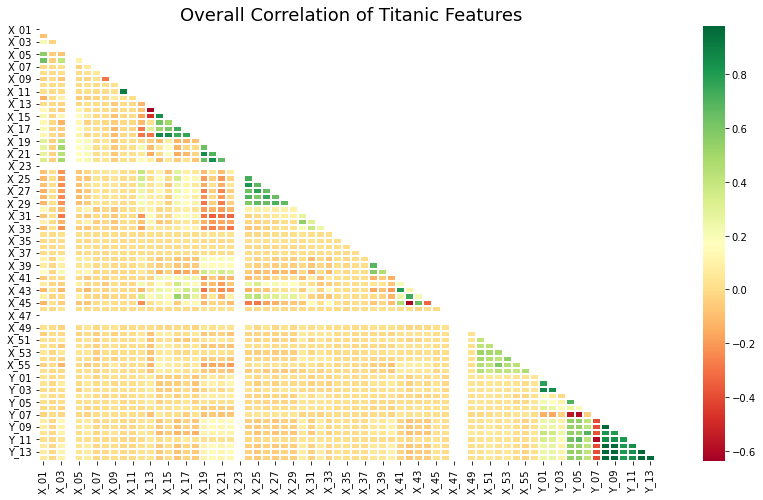

In [390]:
# Co-relation 매트릭스
corr = train_df.corr()
# 마스크 셋업
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 그래프 셋업
plt.figure(figsize=(14, 8))
# 그래프 타이틀
plt.title('Overall Correlation of Titanic Features', fontsize=18)
# Co-relation 매트릭스 런칭
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

In [748]:
train_df = pd.read_csv('data/train.csv')
test_x = pd.read_csv('data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

train_y_info = pd.read_csv('data/meta/y_feature_spec_info.csv')

In [677]:
valid_cols1 = ["X_01",  "X_03"]
valid_cols2 = ["X_05", "X_06", "X_07", "X_09"
               ,  "X_13", "X_14", "X_15", "X_16", "X_17", "X_18", "X_19", "X_20", "X_21", "X_22"]
valid_cols3 = ["X_24", "X_25", "X_26", "X_27", "X_28", "X_29",  "X_34", "X_35", "X_36", "X_37"]
valid_cols4 = ["X_38", "X_39", "X_40", "X_41", "X_42", "X_43", "X_44", "X_45"]
valid_cols5 = ["X_50", "X_51", "X_52", "X_53", "X_54", "X_55", "X_56"]

In [749]:
def outlier_iqr(tmp, i, nm):
    data = tmp[i]
    
    print(np.percentile(data,75))
    print(np.percentile(data,25))
    q25, q75 = np.percentile(data, 25), np.percentile(data,75)
    iqr = q75 - q25
    
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    print('변수 명 : ',i)
    print('IQR : ', iqr)
    print('lower bound : ', lower)
    print('upper bound : ', upper)
    
    tmp[nm] = np.where(data < upper, 
                    np.where(tmp[nm] == 0, 0, 1), 
                    np.where(tmp[nm] == 0, 1, 1))
    tmp[nm] = np.where(data>lower, 
                    np.where(tmp[nm] == 0, 0, 1), 
                    np.where(tmp[nm] == 0, 1, 1))
    
    print("tmp[nm].value_counts() : ", tmp[nm].value_counts());
    return tmp

In [652]:
# 4 23 47 48

In [750]:
X_57 = [0 for i in range(train_x.shape[0])]
len(X_57)
X_57 = pd.DataFrame(X_57)
train_x['X_57'] = X_57

In [595]:
X_04 = [0 for i in range(train_x.shape[0])]
len(X_04)
X_04 = pd.DataFrame(X_04)
train_x['X_04'] = X_04

In [596]:
X_23 = [0 for i in range(train_x.shape[0])]
len(X_23)
X_23 = pd.DataFrame(X_23)
train_x['X_23'] = X_23

In [597]:
X_47 = [0 for i in range(train_x.shape[0])]
len(X_47)
X_57 = pd.DataFrame(X_47)
train_x['X_47'] = X_47

In [598]:
X_48 = [0 for i in range(train_x.shape[0])]
len(X_48)
X_48 = pd.DataFrame(X_48)
train_x['X_48'] = X_48

In [563]:
cols_with_zero_variance = zero_variance(train_x)
print(cols_with_zero_variance)

['X_04', 'X_23', 'X_47', 'X_48', 'X_57']


In [564]:
# 1차 시도 (이상치 수 기준)
cols = ["X_12", "X_13", "X_14","X_16", "X_17", "X_19", "X_20", "X_24", "X_25",  "X_27", "X_42", "X_43", "X_44"]


In [565]:
# 2차 시도 (y와 corr 기준)
cols = ["X_10", "X_11", "X_14","X_15","X_16", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29","X_38", "X_39", "X_40","X_41","X_42","X_43", "X_44","X_45",]


In [566]:
# 2차 시도 (y와 corr 기준) fixed
cols = ["X_14","X_15","X_16", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29","X_38", "X_39", "X_40","X_41","X_42","X_43", "X_44","X_45",]


In [567]:
# 2차 시도 (y와 corr 기준) fixed 2
cols = ["X_14","X_15","X_16", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29", "X_39", "X_40","X_41","X_42","X_43", "X_44","X_45",]


In [568]:
# 2차 시도 (y와 corr 기준) fixed 3
cols = ["X_14","X_15","X_16", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29"]


In [280]:
# 3차 시도 (y와 corr 기준)
cols = ["X_01","X_06", "X_13", "X_14","X_15","X_16", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29","X_38", "X_39", "X_40","X_41","X_42","X_43", "X_44","X_45","X_52","X_55",]


In [724]:
# 2차 시도 (y와 corr 기준) fixed 2 !!!!!!!!!!
cols = ["X_14","X_15", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29", "X_41","X_42","X_43", "X_44","X_45"]


In [249]:
cols = ["X_11", "X_14","X_15", "X_16", "X_17", "X_18", "X_19", "X_20", "X_21","X_22",
        "X_24", "X_25", "X_26", "X_27", "X_28","X_29", 
        "X_30", "X_31", "X_32", "X_33",
        "X_34", "X_35", "X_36", "X_37", 
        "X_39", "X_40","X_41","X_42","X_43", "X_44","X_45"
       ]

In [751]:
# 2차 시도 (y와 corr 기준) fixed 2 !!!!!!!!!!
cols = ["X_41","X_42","X_43", "X_44","X_45"]


In [ ]:
# 4 23 47 48

In [600]:
for i in valid_cols1:
    train_x = outlier_iqr(train_x, i, 'X_04')

train_x['X_04'].value_counts()

69.524
66.465
변수 명 :  X_01
IQR :  3.0589999999999975
lower bound :  60.34700000000001
upper bound :  75.642
tmp[nm].value_counts() :  0    39140
1      467
Name: X_04, dtype: int64
71.77
65.07
변수 명 :  X_03
IQR :  6.700000000000003
lower bound :  51.66999999999999
upper bound :  85.17
tmp[nm].value_counts() :  0    39124
1      483
Name: X_04, dtype: int64


0    39124
1      483
Name: X_04, dtype: int64

In [601]:
for i in valid_cols2:
    train_x = outlier_iqr(train_x, i, 'X_23')

train_x['X_23'].value_counts()

103.144
101.949
변수 명 :  X_05
IQR :  1.1950000000000074
lower bound :  99.55899999999998
upper bound :  105.53400000000002
tmp[nm].value_counts() :  0    39607
Name: X_23, dtype: int64
71.923
68.864
변수 명 :  X_06
IQR :  3.0589999999999975
lower bound :  62.74600000000001
upper bound :  78.041
tmp[nm].value_counts() :  0    39450
1      157
Name: X_23, dtype: int64
29.87
27.89
변수 명 :  X_07
IQR :  1.9800000000000004
lower bound :  23.93
upper bound :  33.83
tmp[nm].value_counts() :  0    38581
1     1026
Name: X_23, dtype: int64
263.96
188.54
변수 명 :  X_09
IQR :  75.41999999999999
lower bound :  37.70000000000002
upper bound :  414.79999999999995
tmp[nm].value_counts() :  0    37456
1     2151
Name: X_23, dtype: int64
0.16
0.13
변수 명 :  X_13
IQR :  0.03
lower bound :  0.07
upper bound :  0.22
tmp[nm].value_counts() :  0    37165
1     2442
Name: X_23, dtype: int64
13.39
13.35
변수 명 :  X_14
IQR :  0.040000000000000924
lower bound :  13.269999999999998
upper bound :  13.470000000000002
tmp[nm].

0    36978
1     2629
Name: X_23, dtype: int64

In [602]:
for i in valid_cols3:
    train_x = outlier_iqr(train_x, i, 'X_47')

train_x['X_47'].value_counts()

2.14
2.09
변수 명 :  X_24
IQR :  0.050000000000000266
lower bound :  1.9899999999999993
upper bound :  2.2400000000000007
tmp[nm].value_counts() :  0    39572
1       35
Name: X_47, dtype: int64
2.12
2.07
변수 명 :  X_25
IQR :  0.050000000000000266
lower bound :  1.9699999999999993
upper bound :  2.2200000000000006
tmp[nm].value_counts() :  0    39503
1      104
Name: X_47, dtype: int64
2.12
2.06
변수 명 :  X_26
IQR :  0.06000000000000005
lower bound :  1.94
upper bound :  2.24
tmp[nm].value_counts() :  0    39332
1      275
Name: X_47, dtype: int64
2.12
2.07
변수 명 :  X_27
IQR :  0.050000000000000266
lower bound :  1.9699999999999993
upper bound :  2.2200000000000006
tmp[nm].value_counts() :  0    39041
1      566
Name: X_47, dtype: int64
2.14
2.09
변수 명 :  X_28
IQR :  0.050000000000000266
lower bound :  1.9899999999999993
upper bound :  2.2400000000000007
tmp[nm].value_counts() :  0    38469
1     1138
Name: X_47, dtype: int64
2.2
2.14
변수 명 :  X_29
IQR :  0.06000000000000005
lower bound :  2.02


0    38062
1     1545
Name: X_47, dtype: int64

In [603]:
for i in valid_cols4:
    train_x = outlier_iqr(train_x, i, 'X_48')

train_x['X_48'].value_counts()

-15.75
-16.16
변수 명 :  X_38
IQR :  0.41000000000000014
lower bound :  -16.98
upper bound :  -14.93
tmp[nm].value_counts() :  0    38829
1      778
Name: X_48, dtype: int64
-15.75
-16.16
변수 명 :  X_39
IQR :  0.41000000000000014
lower bound :  -16.98
upper bound :  -14.93
tmp[nm].value_counts() :  0    38719
1      888
Name: X_48, dtype: int64
-16.4
-16.81
변수 명 :  X_40
IQR :  0.41000000000000014
lower bound :  -17.63
upper bound :  -15.579999999999998
tmp[nm].value_counts() :  0    38690
1      917
Name: X_48, dtype: int64
21.21
21.17
변수 명 :  X_41
IQR :  0.03999999999999915
lower bound :  21.090000000000003
upper bound :  21.29
tmp[nm].value_counts() :  0    38527
1     1080
Name: X_48, dtype: int64
21.09
21.03
변수 명 :  X_42
IQR :  0.05999999999999872
lower bound :  20.910000000000004
upper bound :  21.209999999999997
tmp[nm].value_counts() :  0    38503
1     1104
Name: X_48, dtype: int64
21.24
21.17
변수 명 :  X_43
IQR :  0.06999999999999673
lower bound :  21.03000000000001
upper bound :  21

0    38452
1     1155
Name: X_48, dtype: int64

In [706]:
for i in valid_cols5:
    train_x = outlier_iqr(train_x, i, 'X_57')

train_x['X_57'].value_counts()

134.5389985
126.948571
변수 명 :  X_50
IQR :  7.59042749999999
lower bound :  111.76771600000002
upper bound :  149.71985349999997
tmp[nm].value_counts() :  0    39458
1      149
Name: X_57, dtype: int64
135.170761
127.669758
변수 명 :  X_51
IQR :  7.501002999999997
lower bound :  112.66775200000001
upper bound :  150.172767
tmp[nm].value_counts() :  0    39369
1      238
Name: X_57, dtype: int64
142.7024475
134.4754005
변수 명 :  X_52
IQR :  8.227046999999999
lower bound :  118.02130650000001
upper bound :  159.1565415
tmp[nm].value_counts() :  0    39303
1      304
Name: X_57, dtype: int64
131.618662
124.374525
변수 명 :  X_53
IQR :  7.244136999999995
lower bound :  109.88625100000002
upper bound :  146.106936
tmp[nm].value_counts() :  0    39261
1      346
Name: X_57, dtype: int64
131.487423
124.6978795
변수 명 :  X_54
IQR :  6.789543500000008
lower bound :  111.11879249999998
upper bound :  145.06651000000002
tmp[nm].value_counts() :  0    39200
1      407
Name: X_57, dtype: int64
142.0731015
133

0    39119
1      488
Name: X_57, dtype: int64

In [605]:
def outlier_57(train_x):
    train_x['X_57'] = np.where(train_x['X_04']==0, 0, 
    np.where(train_x['X_23']==0, 0, 
    np.where(train_x['X_47']==0, 0, 
    np.where(train_x['X_48']==0,0,1))))
    return train_x
    


In [606]:
train_x = outlier_57(train_x)

In [607]:
train_x['X_57'].value_counts()

0    39606
1        1
Name: X_57, dtype: int64

In [752]:
for i in cols:
    train_x = outlier_iqr(train_x, i, 'X_57')

train_x['X_57'].value_counts()

21.21
21.17
변수 명 :  X_41
IQR :  0.03999999999999915
lower bound :  21.110000000000003
upper bound :  21.27
tmp[nm].value_counts() :  0    38918
1      689
Name: X_57, dtype: int64
21.09
21.03
변수 명 :  X_42
IQR :  0.05999999999999872
lower bound :  20.940000000000005
upper bound :  21.18
tmp[nm].value_counts() :  0    38748
1      859
Name: X_57, dtype: int64
21.24
21.17
변수 명 :  X_43
IQR :  0.06999999999999673
lower bound :  21.065000000000005
upper bound :  21.34499999999999
tmp[nm].value_counts() :  0    38629
1      978
Name: X_57, dtype: int64
21.19
21.13
변수 명 :  X_44
IQR :  0.060000000000002274
lower bound :  21.039999999999996
upper bound :  21.280000000000005
tmp[nm].value_counts() :  0    38477
1     1130
Name: X_57, dtype: int64
0.19
0.12
변수 명 :  X_45
IQR :  0.07
lower bound :  0.014999999999999986
upper bound :  0.29500000000000004
tmp[nm].value_counts() :  0    38449
1     1158
Name: X_57, dtype: int64


0    38449
1     1158
Name: X_57, dtype: int64

### Feature Selection


In [789]:
cols_with_zero_variance = zero_variance(train_x)

train_x = train_x.drop(cols_with_zero_variance, axis = 1)

test_x = test_x.drop(cols_with_zero_variance, axis = 1)

highly_correlated = [i[1] for i in get_top_correlation(train_x, 1).index]
print(highly_correlated)
train_x = train_x.drop(highly_correlated, axis = 1)

test_x = test_x.drop(highly_correlated, axis = 1)
test_x = test_x.drop('ID', axis=1)

['X_15']


KeyError: "['ID'] not found in axis"

In [ ]:
# 그룹에 대한 feature selection
train_x.shape

In [790]:
test_x.shape

(39608, 48)

### Train
Train dataset is again splitted into train and validation set

In [791]:
def evaluate(params, x_train, y_train, x_test, y_test):
    model = MultiOutputRegressor(LGBMRegressor(objective='regression', n_jobs=-1, **params))
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    nrmse = lg_nrmse(y_test, pred)
    return nrmse

In [792]:
train_X, validation_X, train_Y, validation_Y = train_test_split(train_x, train_y, test_size = 0.2)


In [793]:
lgb_params_space = {
    'max_depth':        hp.choice('max_depth',        np.arange(3, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 9, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.2, 0.9, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'n_estimators':     100,
    'num_leaves':       50,
    'bagging_fraction': hp.uniform("bagging_fraction", 0, 1.0),
}

In [794]:
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=50)


[LightGBM] [Warning] feature_fraction is set=0.7868153857313266, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.7868153857313266
[LightGBM] [Warning] bagging_fraction is set=0.9263003706131228, subsample=0.8488990011155588 will be ignored. Current value: bagging_fraction=0.9263003706131228
[LightGBM] [Warning] feature_fraction is set=0.8843661819727017, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.8843661819727017
[LightGBM] [Warning] bagging_fraction is set=0.8825625266433623, subsample=0.95962343410775 will be ignored. Current value: bagging_fraction=0.8825625266433623
[LightGBM] [Warning] feature_fraction is set=0.8509352043504641, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.8509352043504641
[LightGBM] [Warning] bagging_fraction is set=0.8868555052422203, subsample=0.9722764989814893 will be ignored. Current value: bagging_fraction=0.8868555052422203
[LightGBM] [Warning] fea

[LightGBM] [Warning] feature_fraction is set=0.8866704263891388, colsample_bytree=0.2 will be ignored. Current value: feature_fraction=0.8866704263891388
[LightGBM] [Warning] bagging_fraction is set=0.9221599864389785, subsample=0.9892085867880428 will be ignored. Current value: bagging_fraction=0.9221599864389785
[LightGBM] [Warning] feature_fraction is set=0.8942735056989809, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.8942735056989809
[LightGBM] [Warning] bagging_fraction is set=0.9739690428416147, subsample=0.9346699824756942 will be ignored. Current value: bagging_fraction=0.9739690428416147
[LightGBM] [Warning] feature_fraction is set=0.8741333597043734, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.8741333597043734
[LightGBM] [Warning] bagging_fraction is set=0.9972520435394734, subsample=0.897824369558255 will be ignored. Current value: bagging_fraction=0.9972520435394734
[LightGBM] [Warning] fe

In [ ]:
space = {
    'n_estimators' : hp.quniform('n_estimators', 100, 1500, 50),
    'max_depth': hp.quniform('max_depth', 3, 100, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 10),
    'min_child_samples': hp.quniform('min_child_samples', 10, 300, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.7),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0, 100),
    'reg_lambda': hp.uniform('reg_lambda', 0, 100),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
}

best = fmin(fn = objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 30,
            rstate=np.random.default_rng(1))

In [759]:
best_params

{'bagging_fraction': 0.9610166510748861,
 'colsample_bytree': 5,
 'feature_fraction': 0.5619448083242041,
 'max_depth': 3,
 'min_child_weight': 4,
 'subsample': 0.8354846836454829}

### Inference

In [760]:
test_x = test_x.drop('ID', axis=1)

In [694]:
model = MultiOutputRegressor(LGBMRegressor(**best_params))
model.fit(train_x, train_y)
preds = model.predict(test_x)

In [695]:
pd.DataFrame(preds)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.383297,1.179149,1.071288,13.472673,31.226097,16.768310,3.148302,-26.192801,-26.195799,-22.298689,24.432557,-26.120008,-26.105578,-26.110167
1,1.483523,1.196565,1.125974,13.764450,31.215055,16.627103,3.133529,-26.176398,-26.198439,-22.259938,24.348702,-26.124397,-26.148151,-26.183649
2,1.409379,1.137009,1.069758,14.139093,31.996274,16.849364,3.088461,-25.894610,-25.929497,-22.034860,24.471777,-25.883265,-25.896137,-25.904928
3,1.455771,1.114680,1.048424,14.962189,32.590624,16.805793,3.052365,-25.671580,-25.675645,-21.907524,24.953867,-25.636203,-25.610471,-25.602527
4,1.303131,0.978554,0.924524,14.939616,31.535656,16.929403,3.116875,-25.868166,-25.829147,-22.064313,24.698392,-25.777034,-25.762193,-25.710638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,1.258851,0.994305,0.981286,13.100345,31.416533,16.624428,3.174431,-26.534381,-26.505710,-22.701616,24.384601,-26.397494,-26.397647,-26.392877
39604,1.244659,0.928424,0.975583,13.668684,31.587072,16.752839,3.178128,-26.417522,-26.404218,-22.619890,24.472424,-26.381341,-26.322911,-26.383367
39605,1.248958,0.957678,0.971237,13.121081,31.284558,16.636958,3.175506,-26.510886,-26.469437,-22.685975,24.305580,-26.395023,-26.407380,-26.406890
39606,1.225088,0.899125,0.949546,13.389727,31.198365,16.652045,3.201134,-26.553210,-26.579408,-22.713389,24.397430,-26.490928,-26.474262,-26.492640


### Save Prediction

In [697]:
submit = pd.read_csv('data/sample_submission.csv')
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]

In [699]:
submit.to_csv('data/submit.csv', index=False)